# VLDB Experiments
In this Jupyter Notebook, I wish to conduct the following experiments for VLDB.

Edited: May 23, 2022

Let's design the experiments we're going to use for VLDB with the following varying configs: 
- p = 0.1, 0.5, 1
- Algos = PMW, PMW (random scheduler), PMW, PMW (Round Robin) and Seeded C&R
- Measures = Total Utility, Max Ratio, Empirical Interference

In [1]:
import numpy as np
import pandas as pd
import math
from src.hdmm.error import expected_error, strategy_supports_workload
from src.hdmm.matrix import EkteloMatrix
from typing import Tuple
import string
import random
from itertools import cycle, islice
import src.hdmm.workload as workload
import src.census_workloads as census
from src.workload_selection import workload_selection
import online_workloads as online_workloads
import seaborn as sns
import matplotlib.ticker as mtick



from matplotlib import pyplot as plt
from collections import OrderedDict
from src.hdmm.workload import AllRange

# Algorithms
The following are the algorithms that we wish to implement. They are Private Multiplicative Weights and Cache and Reconstruct. 

### 1. PMW

In [2]:
def pmw_naive(workload, x, analyst_labels, T, eps=0.01, total_k=None, 
         show_messages=False, to_return='error', show_plot=False, show_failure_step=False, eta = None,
             count_threshold=0.1):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries where analysts can run out of privacy budget if they use too much of others'. 
    
    In other words, all analysts share from the same privacy budget. 
    
    Last Updated: 4-23-2022

    Algorithm Parameters: 
    - workload = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    - T = update threshold
    - eps = privacy budget
    - total_k = total number of update steps alloted for the entire group
    - analyst_labels = list of analyst names corresponding to each query in the workload
    
    Output Controls: 
    - show_messages argument determines whether the function will print information such as 
    error scale, threshold, update steps used, etc.
    - to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query in the workload(showing query, d_t_hat, updated, algo_ans, real_ans, 
        abs_error, rel_error). 
        - if 'error', pmw() returns a dictionary for the average absolute error for each analyst
        - if 'pct_ans', pmw() returns a dictionary for the percent of queries answered that meets
        the accuracy threshold set by count_threshold
    - show_plot - T/F whether the function will display a plot
    - show_failure_step - T/F whether function prints what step failure mode is reached
    - count_threshold - this is for the to_return = 'pct_ans' setting. It is the min error threshold 
    that a query answer for us to count the answer as "reasonable" as opposed to "bot". The default
    is 0.1. This functions as another way to  measure the accuracy of the queries that is more similar 
    to how our other functions; i.e., cache and reconstruct either returns an accurate answer or "bot".
    """ 
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    if(eta == None):
        eta = (math.log(m, np.e) / ((math.sqrt(n))) )
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    
    # initialize synthetic databases at time 0 (prior to any queries)
    x_t = np.ones(m) / m
    y_t = np.ones(m) / m

    # initialize tracker lists to construct pandas dataframe at the end 
    x_list = [x_t] # create a list of x_t synthetic database at every time step
    update_list = []
    update_count = 0
    pmw_answers = []
    update_times = [] # record times that database is updated
    d_t_hat_list = []
    
    # initialize total_k, the total number of update steps if not default
    if total_k == None:
        total_k = round(n * math.log(math.sqrt(m)) / 770) #770
        #print(f'{total_k=}')
    
    def lazy_round():
        """
        "Lazy Round" of querying using the stored synthetic database, x_t, in list x_list.
        
        We call this the lazy round because it is contrasted with the updated step where we update the 
        sythetic database and answer the query using the real database.
        """
        update_list.append('no')
        answer = np.dot(query, x_list[time])
        if answer < 0:
            pmw_answers.append(0)
        else: 
            pmw_answers.append(answer)
        x_list.append(x_list[time])
    
    # inititate first instance of SVT with half the budget and k updates; will be reset in the main loop
    SVTtrigger = False 
    SVTepsilon1 = ((eps/2)/2)
    SVTepsilon2 = ((eps/2)/2)
    rho = np.random.laplace(loc=0, scale=(1/SVTepsilon1), size=1)[0]
    #print(rho + T)
    
    
    for time, query in enumerate(workload):
        
        analyst = analyst_labels[time]
        
        # Do one round of sparse vector technique; compute noisy answer by adding Laplacian noise
        A_t = np.random.laplace(loc=0, scale=(total_k/SVTepsilon2), size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + A_t
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        
        # LAZY ROUND: QUERY USING THE SYNTHETIC DATABASE
        if (abs(d_t_hat) <= T + rho):
            d_t_hat_list.append(d_t_hat)
            lazy_round()

        # UPDATE ROUND: UPDATE SYNTHETIC DATABASE AND RETURN NOISY ANSWER, A_T-HAT
        else:
            # noise
            A_t = np.random.laplace(loc=0, scale=(2*total_k/eps), size=1)[0]
            
            # noisy answer
            a_t_hat = (np.dot(query, x_norm)*n ) + A_t
            d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
            d_t_hat_list.append(d_t_hat)
            update_times.append(time)
            
            # step a
            if d_t_hat < 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i in range(len(y_t)):
                y_t[i] = x_list[time][i] * math.exp(-( eta * r_t[i]))# eta is the learning rate
            
            # step b
            x_t = y_t / np.sum(y_t)
            update_count = update_list.count('yes')
            
            # if threshold for num updates is reached, just do a lazy round (synthetic database) answer
            if total_k == 0: 
                if show_failure_step:
                    print(f'Failure mode reached at query number {time}: {query}')
                lazy_round()
                
            # if there are still update steps that the analyst can use, 
            # 1. update the synthetic database
            # 2. answer the query using the noisy answer from the database itself 
            else: 
                x_list.append(x_t)
                update_list.append('yes') # increment number of updates counter
                answer = a_t_hat / np.sum(x)
                
                if answer < 0:
                    pmw_answers.append(0)
                else: 
                    pmw_answers.append(answer)
                
                total_k -= 1 # use one of the total update steps
        
        #print(f'{x_list[time] - x_list[time - 1]=}')
        
        
    update_count = update_list.count('yes')      

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(pmw_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))
    
    if show_messages:
        np.set_printoptions(suppress=True)
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Synthetic Database (after) = {x_list[len(x_list) - 1] * sum(x)}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Synthetic Database (before) = {x_list[0]}\n')
        print(f'Synthetic Database (after, norm) = {x_list[len(x_list) - 1]}\n')
        print(f'Difference btw. Final Synthetic and true database = {x_list[len(x_list) - 1] - x_norm}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{T=}\n')
        print(f'Error Scale Query Answer= {2*((2*total_k/eps)**2)}\n')
        print(f'Error Scale SVT= {2*((2*total_k/SVTepsilon2)**2)}\n')
        print(f'Update Parameter Scale = {eta}\n')
        print(f'{delta=}\n')
        
    if show_plot: 
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[abs_line,rel_line])
        plt.xticks(range(0, len(workload), round(len(workload)/5)))
    
    if to_return == "pd":
        # hacky fix: remove the first synthetic database to keep length of lists consistent with the
        # other lists that comprise of the pandas dataframe
        x_list.pop(0).tolist() 
        d = {
            'algo_ans': pmw_answers,
            'real_ans': real_ans.tolist(),
            'queries': workload.tolist(), 
            'updated': update_list,
            'abs_error': abs_error,               
            'rel_error': rel_error,
            'synthetic database': x_list,
            'analyst': analyst_labels,
            'd_t_hat': d_t_hat_list, 

             }
        test_data = pd.DataFrame(data=d)
        #test_data = test_data.round(3)
        return test_data
    
    if to_return == "error":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,               
             'rel_error': rel_error,}
        data = pd.DataFrame(data=d)
        data = data.round(3)
        
        analyst_error = {}
        for analyst in list(sorted(analyst_labels)):
            analyst_error[analyst] = data[data.analyst==analyst]['abs_error'].sum()
        return analyst_error
    
    if to_return == "tse":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,}
        data = pd.DataFrame(data=d)
        data['squared_err'] = data['abs_error'] ** 2
        
        analyst_error = {}
        for analyst in list(sorted(analyst_labels)):
            analyst_error[analyst] = data[data.analyst==analyst]['abs_error'].sum()
        return analyst_error
    
    if to_return == "pct_ans":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,}
        data = pd.DataFrame(data=d)
        
        pct_answered = {}
        for analyst in sorted(list(set(analyst_labels))):
            pct_answered[analyst] = data[(data['abs_error'] < count_threshold) & 
                                         (data.analyst==analyst)]['abs_error'].count()/len(data[data.analyst==analyst]) * 100
        return pct_answered

In [3]:
# pmw_independent: write pmw for one person. 
# create wrapper function called pmw_independent() that takes in the workloads and workload labels. Run PMW for each analyst, separate their workloads based on analysts. 

def pmw_independent(w, input_x, labs, input_T, input_eps=0.01, input_k=None):
    """
    Wrapper function that calls pmw2() to simulate PMW for each independent person. 
    
    Takes a stream of workloads and analyst labels and separates them into distinct workloads for each analyst. 
    Runs pmw_naive() on that particular workload for each analyst. Returns a dictionary of percent answered
    """
    indices = {} # k: analyst, v: row indices of queries in the workloads
    for i, analyst in enumerate(labs):
        if analyst not in indices.keys(): 
            indices[analyst] = []
        indices[analyst].append(i)

    workloads = {} # k: analyst, v: the analyst's workload
    for analyst in indices.keys():
        workloads[analyst] = w[indices[analyst], :]
    #print(workloads)

    all_analyst_error_dic = {}
    
    for analyst in workloads.keys():
        single_analyst_error = pmw_naive(workload=workloads[analyst], 
                                    eps=input_eps,
                                    x=input_x, 
                                    T=input_T, 
                                    total_k = input_k,
                                    analyst_labels=[analyst]*len(workloads[analyst]), 
                                    to_return="pct_ans",
                                    count_threshold=0.01,
                                    show_messages=False)
        all_analyst_error_dic.update(single_analyst_error)
    return all_analyst_error_dic

pmw_independent(np.vstack((online_workloads.identity(5), 
                           online_workloads.identity(5))), 
                input_x=np.array([1, 1, 1, 1, 1]), 
                input_T=40, 
                input_eps=1, 
                labs=['A'] * 2 + ['B'] * 6 + ['A'] * 2, 
                )

{'A': 100.0, 'B': 100.0}

### 2. Cache and Reconstruct

In [4]:
def cache(query, storage, ans, error):
    """caches query into a dictionary with values of (ans, error)"""
    storage[np.array2string(query)] = (ans, error)
    return storage
    
def is_reusable(query, storage):
    """returns whether or not a query is in a strategy matrix 
    (cache)"""
    return np.array2string(query) in storage

def reuse(query, storage):
    """returns tuple with (query answer, error) stored in 
    a storage dictionary"""
    return storage[np.array2string(query)]

def cache_and_reconstruct(workload, x, eps=0.01, k=0, analyst_labels=[], to_return = "pd", count_threshold=0.1):
    """
    Takes in workload, database, eps (privacy budget), k (number of total update steps PER ANALYST). 
    
    Returns list of error per query.
    """
    budgets = {}
    for analyst in list(set(analyst_labels)): 
        budgets[analyst] = k # each analyst starts with k update steps
    
    numAnalysts = len(budgets)
    error_list = []
    laplace_list = [] # if the algorithm simply added noise to the answer
    used_reconstruct_list = []
    used_reuse_list = []
    
    storage = {} # storage dictionary for reuse, k: query,v: error
    strategy = workload[0:0] # workload matrix for reconstruction, 
    # make strategy = empty workload to create matrix of same dtype to be used in reconstruct step (avoid error)
    
    n = x.sum()
    x_norm = x/sum(x) # normalize database
    
    def add_to_strategy(query, strategy):
        """Append query to the end fo the strategy matrix"""
        return np.concatenate((strategy, query), axis = 0)
    
    for i, query in enumerate(workload): 
        query = np.expand_dims(query, axis = 0)
        analyst = analyst_labels[i]
        
        # If query has answered before, then use old query answer
        if is_reusable(query, storage): 
            abs_error = reuse(query, storage)
            
            error_list.append(abs_error)
            used_reconstruct_list.append(False) 
            laplace_list.append(False)
            used_reuse_list.append(True)
            strategy = add_to_strategy(query, strategy)
            
        # If analyst still has update steps left
        elif budgets[analyst] > 0: 
            noise = np.random.laplace(0, (k * numAnalysts) / (n * eps), 1)[0]
            noisy_ans = (np.dot(query, x_norm)) + noise
            true_ans = np.matmul(query, x_norm)
            abs_error = np.abs(noisy_ans - true_ans)[0]
            
            error_list.append(abs_error) # *n
            
            storage[np.array2string(query)] = abs_error
            budgets[analyst] -= 1 
            strategy = add_to_strategy(query, strategy)
            laplace_list.append(True)
            used_reconstruct_list.append(False)
            used_reuse_list.append(False)
        
        # If query is reconstructable, then reconstruct
        elif strategy_supports_workload(EkteloMatrix(query), EkteloMatrix(strategy)): # how to convert numpy array to ektelo matrix https://github.com/yikai-wu/Multi-Analyst-DP/blob/fadc7ac1d20199e8b31914f44323e51a05ed072d/src/hdmm/matrix.py#L34
            
            squared_error = expected_error(query, strategy, len(strategy) / (k * numAnalysts) * eps) # do i mult by 100
            abs_error = math.sqrt(squared_error) / n #
            
            storage[np.array2string(query)] = abs_error
            error_list.append(abs_error)
            laplace_list.append(False)
            used_reconstruct_list.append(True) 
            used_reuse_list.append(False)
            strategy = add_to_strategy(query, strategy)
            
        # If analyst ran out of update steps
        else: # this analyst has run out of update steps
            error_list.append(None)
            laplace_list.append(False)
            used_reconstruct_list.append(False)
            used_reuse_list.append(False)
            
    if to_return == "pct_ans":
        d = {'analyst': analyst_labels,
             'abs_error': error_list,}
        data = pd.DataFrame(data=d)
        
        pct_answered = {}
        for analyst in sorted(list(set(analyst_labels))):
            pct_answered[analyst] = data[(data['abs_error'] < count_threshold) & 
                                         (data.analyst==analyst)]['abs_error'].count()/len(data[data.analyst==analyst]) * 100
        return pct_answered
    
    if to_return == "pd":
        d = {'queries': workload.tolist(), 
            'abs_error': error_list,
            'used_reconstruct': used_reconstruct_list,
            'used_reuse': used_reuse_list,
            'laplace': laplace_list,
            'analyst': analyst_labels,
        }
        test_data = pd.DataFrame(data=d)
        test_data = test_data.round(3)
        test_data['isNa'] = np.where(test_data.abs_error.isnull(), True, False)
        return test_data

# Schedulers
The following are the schedulers that we will use. There are 2 schedulers: random scheduler and round robin scheduler. 

### 1. Random Scheduler

Create a scheduler that schedules Alice's queries with a probability of p and all other analysts' queries with a probability of (1 - p) / (number of analysts - 1)

In [5]:
def random_scheduler(analysts: list, workloads: list, p : int = 0.1) -> Tuple: 
    """
    In a system with n analysts, this system schedules Alice's queries with a probability of p and 
    other analysts' queries with an equal probability of (1 - p) / (n - 1), i.e. uniform probability.
    
    Returns new workload of queries (2D np.array) and analyst labels (list) that label each query in the 
    new workload. 
    
    Takes: 
    - analysts: list of analyst names
    - workloads: list of workloads in order where analyst[i] has workloads[i]
    - p: probability that Alice has her query answered at any given step
    
    Returns: 
    - W_final: final workload
    - analyst_labels: labels the final workload where analyst_labels[i] is the analyst with query at W_final[i]
    
    Date: 5-27-2022
    """

    workloads_dict = dict(zip(analysts, workloads))

    # gives alice p, all other analysts equal weight left
    weights = [p if analyst=='a' else (1-p)/(len(analysts) - 1) for analyst in analysts] 
    # points the query that analyst is at, e.g., {'a': 0, 'b': 0, ...}
    pointers = {analyst: 0 for analyst in analysts}

    num_queries_left = {analyst: len(workloads_dict[analyst]) for analyst in analysts}

    ordering = random.choices(analysts, weights, k=5000)
    iterator = cycle(ordering)
    
    W = []
    analyst_labels = []

    for analyst in iterator: 
        if num_queries_left[analyst] > 0: 
            # add query to the workload
            pointer = pointers[analyst]
            W.append(workloads_dict[analyst][pointer])
            analyst_labels.append(analyst)

            num_queries_left[analyst] -= 1
            pointers[analyst] += 1
        if sum(num_queries_left.values()) == 0: # if no more queries left to ask
            break

    W_final = np.array(W)
    #list(zip(analyst_labels, W_final))
    return W_final, analyst_labels

In [6]:
# test random_scheduler(): 
analysts = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
a = np.array([[1, 1, 1, 1], [1, 1, 1, 1]])
b = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])
c = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])
d = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])
e = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])
f = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])
g = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])
h = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])
i = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])
j = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])
workloads = [a, b, c, d, e, f, g, h, i, j]

random_scheduler(analysts, workloads, 0.5)

(array([[1, 1, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]),
 ['a',
  'f',
  'j',
  'a',
  'f',
  'c',
  'b',
  'j',
  'c',
  'i',
  'd',
  'i',
  'd',
  'b',
  'g',
  'e',
  'e',
  'g',
  'h',
  'h'])

### 2. Round Robin

In [7]:
def roundrobin(*iterables):
    "roundrobin('ABC', 'D', 'EF') --> A D E B F C"
    # Recipe credited to George Sakkis
    num_active = len(iterables)
    nexts = cycle(iter(it).__next__ for it in iterables)
    while num_active:
        try:
            for next in nexts:
                yield next()
        except StopIteration:
            # Remove the iterator we just exhausted from the cycle.
            num_active -= 1
            nexts = cycle(islice(nexts, num_active))

def rr_scheduler(analysts: list, workloads: list) -> Tuple:
    """
    Adapting itertools' roundrobin() code to np workloads and analyst labels. 
    
    Takes two parallel lists: 
    - analysts - list of each analyst 
    - workloads - list of each workload; analysts[i] owns workloads[i]
    
    Returns Tuple of two parallel lists: 
    - analyst_labels - list of shuffled analyst labels s.t. analyst_labels[i] owns final_workload[i] query 
    - final_workload - np.array shuffled workload
    """
    analyst_labels = list(roundrobin(*[[analysts[i]] * len(workloads[i]) for i in range(len(analysts))]))
    final_workload = np.vstack(list(roundrobin(*workloads)))
    
    return final_workload, analyst_labels

In [8]:
# test rr_scheduler():

analysts = ['a', 'b', 'c', 'd']
a = np.array([[1, 1, 1, 1],
              [1, 1, 1, 1]])
b = np.array([[0, 0, 0, 0],
              [0, 0, 0, 0]])
c = np.array([[1, 0, 1, 0],
              [1, 0, 1, 0]])
d = np.array([[1, 0, 1, 0], [1, 0, 1, 0], [1, 0, 1, 0]])
workloads = [a, b, c, d]

rr_scheduler(analysts, workloads)

(array([[1, 1, 1, 1],
        [0, 0, 0, 0],
        [1, 0, 1, 0],
        [1, 0, 1, 0],
        [1, 1, 1, 1],
        [0, 0, 0, 0],
        [1, 0, 1, 0],
        [1, 0, 1, 0],
        [1, 0, 1, 0]]),
 ['a', 'b', 'c', 'd', 'a', 'b', 'c', 'd', 'd'])

# Tests

In [9]:
# Create test cases: 
a = np.array([[1, 1, 1, 1],
              [1, 1, 1, 1]])
b = np.array([[0, 0, 0, 0],
              [0, 0, 0, 0]])
c = np.array([[1, 0, 1, 0],
              [1, 0, 1, 0]])

# round robin would return: 
# [1, 1, 1, 1]
# [0, 0, 0, 0]
# [1, 0, 1, 0]
# [1, 1, 1, 1]
# [0, 0, 0, 0]
# [1, 0, 1, 0]

# skewed scheduler with p = 1 would return: 
# [1, 1, 1, 1]
# [1, 1, 1, 1]
# either [0, 0, 0, 0] or [1, 0, 1, 0]
# either [0, 0, 0, 0] or [1, 0, 1, 0]
# either [0, 0, 0, 0] or [1, 0, 1, 0]
# either [0, 0, 0, 0] or [1, 0, 1, 0]

# skewed scheduler with p = 0 would return: 
# either [0, 0, 0, 0] or [1, 0, 1, 0]
# either [0, 0, 0, 0] or [1, 0, 1, 0]
# either [0, 0, 0, 0] or [1, 0, 1, 0]
# either [0, 0, 0, 0] or [1, 0, 1, 0]
# [1, 1, 1, 1]
# [1, 1, 1, 1]

# skewed scheduler with p = 0.333 would return something similar to round robin.

# 5-27 (Top Left Corner)

First, let's start doing one box (the top left corner). For p = 0.1, let's find the total utility for PMW (random scheduler), PMW (Round Robin) and Seeded C&R. Let's do this 500 times for PMWRS, PMWRR, and SCAR.

In [10]:
# workload parameters
n=64
W_name = ['identity', 'H2', 'race1', 'race2', 'race3', 'custom', 'prefix_sum']#, 'total',]
W_lst = [online_workloads.identity(n), online_workloads.H2(n), online_workloads.race1(), online_workloads.race2(), online_workloads.race3(), online_workloads.custom(n), online_workloads.prefix_sum(n),] # online_workloads.total(n),]

# database
data_path = "migration_tworace.csv"
x_race = pd.read_csv(data_path, header=None).to_numpy().T[1] 
database = np.concatenate([x_race[:32], x_race[:32]]) # truncate for the first 32 twice for symmetry purposes



In [11]:
def vldb_exp(p_list = [0.1, 0.5, 0.9], t = 10, epsilon = 1):
    """
    Run VLDB experiments. Implement the following algs. Return dictionary of dataframes
    of the following experiments in different settings of p (probability that Alice has 
    her query answered at any time step):
    - PMW (BL*: independent, strawman arg, generally a bad idea to prove our alg is better), 
    - PMW (OPT*: optimal in terms of overall error, we don’t care about desiderata, no changes)
    - Seeded C&R
    - PMW (Randomized Scheduler, p is always 0.1)
    - PMW (RR*, always the same) 
    """
    test_data_dics = {}
    
    for p in p_list:
        bl_pctans = []
        rr_pctans = []
        rs_pctans = []
        opt_pctans = []
        cr_pctans = []
        for i in range(10):
            # 1. generate workloads
            # generate 10 workloads, one for each analyst
            c = np.random.randint(len(W_lst))
            analysts = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
            workloads = [W_lst[c] for i in analysts]

            # 2. use each algorithm

            # bl - independent pmw, strawman arg
            W, analyst_labels = random_scheduler(analysts, workloads, p) # random ordering
            bl_pctans_dict = pmw_independent(W, 
                                             input_x=database, 
                                             input_T=40, 
                                             input_eps=epsilon/len(analysts), 
                                             labs=analyst_labels)
            bl_pctans.append(sum(bl_pctans_dict.values()) / len(analysts))

            # opt - pmw with skewed ordering based on p
            opt_pctans_dict = pmw_naive(W, 
                                        database, 
                                        analyst_labels, 
                                        eps=epsilon, 
                                        T=40, 
                                        to_return='pct_ans', 
                                        count_threshold=0.01)
            opt_pctans.append(sum(opt_pctans_dict.values()) / len(analysts))

            # cr - c&r with skewed ordering based on p
            cr_pctans_dict = cache_and_reconstruct(W, 
                                                   database, 
                                                   epsilon, 
                                                   5, 
                                                   analyst_labels, 
                                                   to_return = "pct_ans", 
                                                   count_threshold=0.01)
            cr_pctans.append(sum(cr_pctans_dict.values()) / len(analysts))

            # rs - random scheduler, p is always 0.1
            W, analyst_labels = random_scheduler(analysts, workloads, 0.1)
            rs_pctans_dict = pmw_naive(W, 
                                       database, 
                                       analyst_labels, 
                                       eps=epsilon, 
                                       T=40, 
                                       to_return='pct_ans', 
                                       count_threshold=0.01)
            rs_pctans.append(sum(rs_pctans_dict.values()) / len(analysts))

            # rr - pmw with round robin ordering
            W, analyst_labels = rr_scheduler(analysts, workloads)
            rr_pctans_dict = pmw_naive(W, 
                                       database, 
                                       analyst_labels, 
                                       eps=epsilon, 
                                       T=40, 
                                       to_return='pct_ans',
                                       count_threshold=0.01)
            rr_pctans.append(sum(rr_pctans_dict.values()) / len(analysts))


        d = {'bl': bl_pctans,
             'opt': opt_pctans,
             'cr': cr_pctans,
             'rs': rs_pctans,
            'rr': rr_pctans,
            }

        test_data = pd.DataFrame(data=d)
        test_data_dics[p] = test_data

    return test_data_dics

In [12]:
dics = vldb_exp()

In [13]:
dics

{0.1:           bl        opt          cr         rs          rr
 0  40.405405  41.621622   45.675676  34.729730   40.270270
 1  30.312500  27.031250   50.312500  27.343750   25.156250
 2  30.000000  90.000000  100.000000  80.000000   80.000000
 3  36.929134  42.362205   62.913386  42.362205   41.417323
 4  22.857143  94.285714   98.571429  95.714286  100.000000
 5  48.571429  68.428571   47.571429  68.000000   66.571429
 6  46.000000  66.571429   46.571429  68.142857   67.000000
 7  10.000000  90.000000  100.000000  90.000000   70.000000
 8  30.468750  26.875000   49.687500  26.250000   26.093750
 9  39.459459  35.135135   47.432432  36.216216   38.783784,
 0.5:           bl         opt          cr         rs         rr
 0  10.000000   80.000000  100.000000  90.000000  90.000000
 1  32.857143   97.142857   98.571429  95.714286  94.285714
 2  32.968750   27.812500   50.468750  27.343750  26.093750
 3  25.714286   95.714286  100.000000  94.285714  98.571429
 4  32.857143   98.571429   9

In [14]:
def vldb_exp_new(p_list = [0.1, 0.5, 0.9], t = 10, epsilon = 1):
    """
    Run VLDB experiments. Implement the following algs. Return dictionary of dataframes
    of the following experiments in different settings of p (probability that Alice has 
    her query answered at any time step):
    - PMW (BL*: independent, strawman arg, generally a bad idea to prove our alg is better), 
    - PMW (OPT*: optimal in terms of overall error, we don’t care about desiderata, no changes)
    - Seeded C&R
    - PMW (Randomized Scheduler, p is always 0.1)
    - PMW (RR*, always the same) 
    
    Last updated: July 14, 2022
    """
    df_dic = {}
    
    def save_value(alg, p, val):
        """
        Helper function to save the value of the calculation into the dictionary df_dic
        """
        if f'{alg}{p}' not in df_dic:
            df_dic[f'{alg}{p}'] = []
        df_dic[f'{alg}{p}'].append(val)
    
    for i in range(t):
        # 1. generate workloads
        # generate 10 workloads, one for each analyst
        c = np.random.randint(len(W_lst))
        analysts = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
        workloads = [W_lst[c] for i in analysts]
        
        for p in p_list:
            
            # 2. use each algorithm

            # bl - independent pmw, strawman arg
            W, analyst_labels = random_scheduler(analysts, workloads, p) # random ordering
            bl_pctans_dict = pmw_independent(W, 
                                             input_x=database, 
                                             input_T=40, 
                                             input_eps=epsilon/len(analysts), 
                                             labs=analyst_labels)
            save_value('Ind', p, sum(bl_pctans_dict.values()) / len(analysts))
            
            # opt - pmw with skewed ordering based on p
            opt_pctans_dict = pmw_naive(W, 
                                        database, 
                                        analyst_labels, 
                                        eps=epsilon, 
                                        T=40, 
                                        to_return='pct_ans', 
                                        count_threshold=0.01)
            save_value('PMW', p, sum(opt_pctans_dict.values()) / len(analysts))

            # cr - c&r with skewed ordering based on p
            cr_pctans_dict = cache_and_reconstruct(W, 
                                                   database, 
                                                   epsilon, 
                                                   5, 
                                                   analyst_labels, 
                                                   to_return = "pct_ans", 
                                                   count_threshold=0.01)
            save_value('SCR', p, sum(cr_pctans_dict.values()) / len(analysts))

            # rs - random scheduler, p is always 0.1
            W, analyst_labels = random_scheduler(analysts, workloads, 0.1)
            rs_pctans_dict = pmw_naive(W, 
                                       database, 
                                       analyst_labels, 
                                       eps=epsilon, 
                                       T=40, 
                                       to_return='pct_ans', 
                                       count_threshold=0.01)
            save_value('RS', p, sum(rs_pctans_dict.values()) / len(analysts))

            # rr - pmw with round robin ordering
            W, analyst_labels = rr_scheduler(analysts, workloads)
            rr_pctans_dict = pmw_naive(W, 
                                       database, 
                                       analyst_labels, 
                                       eps=epsilon, 
                                       T=40, 
                                       to_return='pct_ans',
                                       count_threshold=0.01)
            save_value('RR', p, sum(rr_pctans_dict.values()) / len(analysts))

        test_data = pd.DataFrame(data=df_dic)

    return test_data

# Plot

In [15]:
sns.set(font_scale=2)
sns.set_style("white")

In [16]:
test_data = vldb_exp_new(t=5)

In [17]:
artifactspath = "/Users/albertsun/Projects/artifacts/algexperiments/"

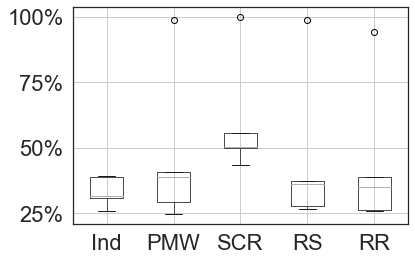

In [18]:
test_data_1 = test_data.iloc[:,:5]
test_data_1.columns = test_data_1.columns.str.rstrip("0.1")
ax = test_data_1.boxplot()
#plt.title('Alice gets her queries \nanswered with p = 0.1')
#plt.ylabel('Queries Answered')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig(artifactspath + '0.1acc.pdf', bbox_inches='tight')

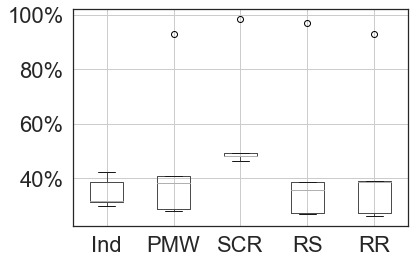

In [23]:
test_data_2 = test_data.iloc[:,5:10]
test_data_2.columns = test_data_2.columns.str.rstrip("0.5")
ax = test_data_2.boxplot()
#plt.title('Alice gets her queries \nanswered with p = 0.5')
#plt.ylabel('Queries Answered')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig(artifactspath + '0.5acc.pdf', bbox_inches='tight')

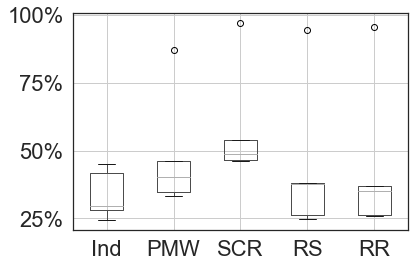

In [24]:
test_data_3 = test_data.iloc[:,10:15]
test_data_3.columns = test_data_3.columns.str.rstrip("0.9")
ax = test_data_3.boxplot()
#plt.title('Alice gets her queries \nanswered with p = 0.9')
#plt.ylabel('Queries Answered')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig(artifactspath + '0.9acc.pdf', bbox_inches='tight')

Experiment parameters: 
- eps = 1, 
- count threshold = 0.01, 
- workload = random practical workload (identity, h2, census, etc.), 
- database = practical census size 64 database
- exp run = 100 times

In [21]:
# Finish by Friday: 
# Rename the x values with just the acronym
# Get info about presentation on Thursday